# ResNet20 on CIFAR-10

Based on https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb

*the model was trained in google colab with `batch=32` and no pixeal mean used*

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from datetime import datetime, date
import time
import serial
import glob # for querying files within directory
import os # for filesize
from sys import platform

print("Tensorflow Version:\t", tf.__version__)
print("Numpy Version:\t", np.__version__)
print("Pandas Version:\t", pd.__version__)

Tensorflow Version:	 2.2.0
Numpy Version:	 1.19.0
Pandas Version:	 1.0.5


In [19]:
model_name = '01bA_ResNet20_CIFAR-10'

GPU for training with Colab

In [3]:
%%script false --no-raise-error

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

### Getting CIFAR-10 dataset

training data x shape: (50000, 32, 32, 3)
training data y shape: (50000, 1)
[7]


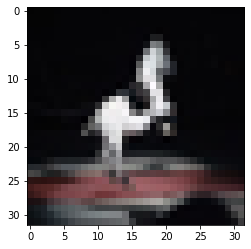

In [4]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("training data x shape:", x_train.shape)
print("training data y shape:", y_train.shape)


plt.imshow(x_train[321].squeeze())
print(y_train[321])

#### Set input and output length globals for later (macros for mbed)

In [5]:
INPUT_LENGTH = x_test[1].flatten().shape[0]
OUTPUT_LENGTH = 10

### Exploring the data
#### Normalize dataset

In [6]:
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255

print("training data shape:", x_train_normalized.shape)
print("test data shape:", x_test_normalized.shape)

training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [7]:
import seaborn as sns
%matplotlib widget

sns.set(context='paper', style="ticks", color_codes=True, font='Times New Roman', font_scale=1, rc={"axes.grid": True })
sns.set_palette("muted")

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    #plt.style.use(['dark_background'])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_normalized[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]], fontsize=16)
plt.show()


plt.savefig('CIFAR-10_examples.pdf')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Create the model

In [8]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200

USE_AUGMENTATION = True
# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = False

NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]

# Computed depth from supplied model parameter n
DEPTH = COLORS * 6 + 2

In [9]:
print("training data y shape:", y_train.shape)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("training data y shape with categories:", y_train.shape)

training data y shape: (50000, 1)
training data y shape with categories: (50000, 10)


In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

The following code implements a ResNet block. This includes two convolutional layers with a skip connection. Both V1 and V2 of ResNet make use of this type of layer.

In [14]:
def resnet_layer(inputs,
                 num_filters=15,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

ResNet V1
- K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. arXiv preprint arXiv:1512.03385,2015.



In [15]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 15
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Create the neural network
with tf.device('/device:GPU:0'):
  model = resnet_v1(input_shape=input_shape, depth=DEPTH)

  model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
                metrics=['accuracy'])
  model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10, 10)
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 15)   420         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 32, 15)   60          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 15)   0           ba

In [20]:
model.save('keras-model/'+ model_name+'.h5')

In [12]:
# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Run training
# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    with tf.device('/device:GPU:0'):
      # Fit the model on the batches generated by datagen.flow().
      model.fit_generator(datagen.flow(x_train, y_train, 
                          batch_size=BATCH_SIZE),
                          validation_data=(x_test, y_test),
                          epochs=EPOCHS,
                          callbacks=callbacks)

### Load the model
*continue here if you want to load a pretrained model*

In [13]:
tf_model_file = './keras-model/01d_ResNet20_CIFAR-10.h5'
tf_model = tf.keras.models.load_model(tf_model_file)
tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Evaluate against the test set

[Losses Documentation](https://keras.io/api/losses/)


We used the `categorical_crossentropy` loss for training.

In [14]:
score = tf_model.evaluate(x=x_test_normalized, y=y_test, verbose=0)

tf_model_loss = score[0]
tf_model_accuracy = score[1]

print('Test accuracy:\t', tf_model_accuracy)
print('Test loss:\t', tf_model_loss)

Test accuracy:	 0.9185000061988831
Test loss:	 0.4342728555202484


### Running a single inference

Picks a random image from testset and then runs local inference using the original Keras model.

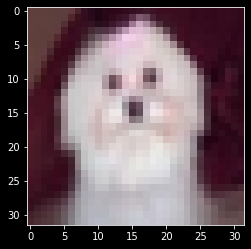

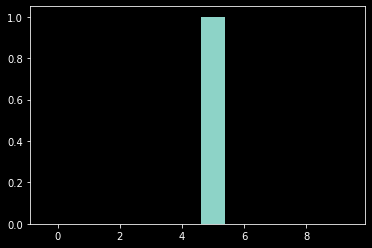

In [23]:

# pick a random image
image_no = np.random.randint(10000)

# use a single example image from the normalized training set
result = tf_model.predict(np.array( [ x_test_normalized[image_no] ] ))

plt.imshow(x_test_normalized[image_no].squeeze(), cmap=plt.cm.gray_r)
plt.show()
plt.figure()
plt.bar(np.arange(10), result[0])
plt.show()